<a href="https://colab.research.google.com/github/DSGPproject/DSGP_model/blob/main/mat_not_working_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#this is importing the stuff

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

import tensorflow.keras as tfk
import tensorflow.keras.layers as tfl

import matplotlib.pyplot as plt

import numpy as np

%load_ext tensorboard

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
BATCH_SIZE = 32 #not sure
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=25 # iterations , passes made to find patterns/trends
#when the number of epochs are very high, the model memorises the images and does not find the patterns. so val accuracy is low

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory( #loading the dataset
     "/content/drive/MyDrive/dataset/unchanged",
    seed=123,
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)
class_names = dataset.class_names
class_names

Found 895 files belonging to 8 classes.


['Anthracnose',
 'algal leaf',
 'bird eye spot',
 'brown blight',
 'gray light',
 'healthy',
 'red leaf spot',
 'white spot']

In [8]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[3 7 3 6 0 3 7 7 3 4 5 6 4 5 5 3 6 3 0 5 6 6 3 6 2 2 3 5 1 3 2 0]


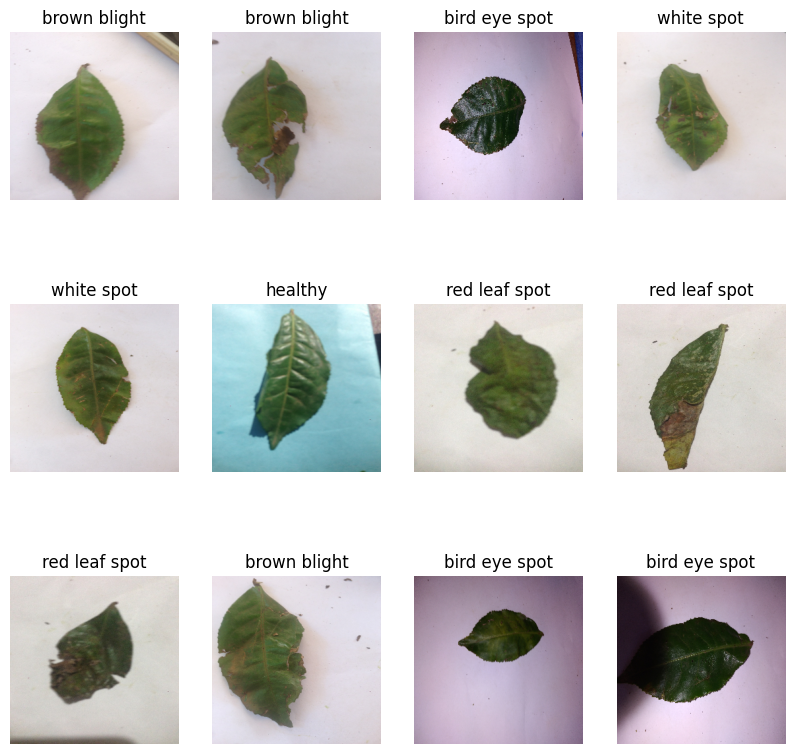

In [9]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [10]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)

    return train_ds, val_ds, test_ds
#---------------------------------------------------

#getting the 3 things
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [11]:
#data augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
])


In [12]:
#applying the augmentation to the train ds

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model=tfk.Sequential([
    # 1
    tfl.Conv2D(32,3,padding='same'),
    tfl.BatchNormalization(),
    tfl.ReLU(),
    tfl.MaxPooling2D((2,2)),
    #2
    tfl.Conv2D(64,3,padding='same'),
    tfl.BatchNormalization(),
    tfl.ReLU(),
    tfl.MaxPooling2D((2,2)),
    #3
    tfl.Conv2D(128,3,padding='same'),
    tfl.BatchNormalization(),
    tfl.ReLU(),
    tfl.MaxPooling2D((2,2)),

    tfl.Flatten(),

    tfl.Dense(64,),
    tfl.BatchNormalization(),
    tfl.ReLU(),
    tfl.Dropout(rate= 0.2, seed= 123),

    tfl.Dense(128),
    tfl.BatchNormalization() ,
    tfl.ReLU(),
    tfl.Dropout(rate= 0.2, seed= 123),


    tfl.Dense(256),
    tfl.BatchNormalization() ,
    tfl.ReLU(),
    tfl.Dropout(rate= 0.2, seed= 123),


    tfl.Dense(8,activation='softmax')
])


In [15]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)

from tensorflow.keras.callbacks import EarlyStopping
#. the EarlyStopping callback
early_stopping = EarlyStopping(
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
    monitor='val_loss',  # Metric to monitor for improvement (e.g., 'val_loss' or 'val_accuracy')
    mode='min'  # 'min' means training will stop when the quantity monitored has stopped decreasing (e.g., val_loss)
)


model.compile(optimizer=tfk.optimizers.Adamax(learning_rate= lr_schedule),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [16]:
history = model.fit(train_ds,validation_data=val_ds, batch_size=32,epochs=25,callbacks=[early_stopping])

Epoch 1/25
22/22 [==============================] - 325s 9s/step - loss: 1.7078 - accuracy: 0.3471 - val_loss: 2.7959 - val_accuracy: 0.2344
Epoch 2/25
22/22 [==============================] - 147s 7s/step - loss: 1.1746 - accuracy: 0.5178 - val_loss: 1.8809 - val_accuracy: 0.2812
Epoch 3/25
22/22 [==============================] - 148s 7s/step - loss: 0.9890 - accuracy: 0.5789 - val_loss: 1.8672 - val_accuracy: 0.2969
Epoch 4/25
22/22 [==============================] - 148s 7s/step - loss: 0.8964 - accuracy: 0.6145 - val_loss: 1.5427 - val_accuracy: 0.3125
Epoch 5/25
22/22 [==============================] - 158s 7s/step - loss: 0.8148 - accuracy: 0.6643 - val_loss: 1.6414 - val_accuracy: 0.3438
Epoch 6/25
22/22 [==============================] - 150s 7s/step - loss: 0.7806 - accuracy: 0.6714 - val_loss: 1.5450 - val_accuracy: 0.3594
Epoch 7/25
22/22 [==============================] - 150s 7s/step - loss: 0.7756 - accuracy: 0.6486 - val_loss: 1.4740 - val_accuracy: 0.5000
Epoch 8/25
22

In [17]:
model.evaluate(val_ds)

2/2 [==============================] - 5s 3s/step - loss: 0.8479 - accuracy: 0.6875


[0.8478520512580872, 0.6875]

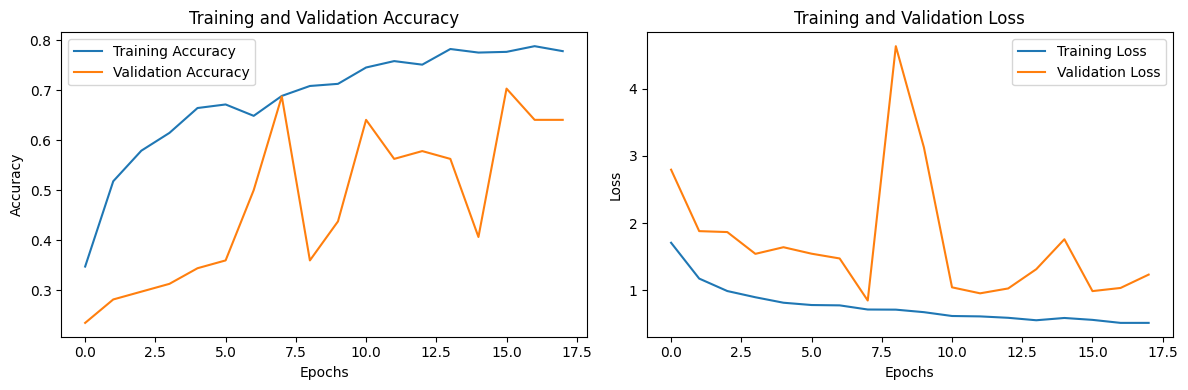

In [18]:
# Plotting the training history
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

first image to predict
actual label: white spot
1/1 [==============================] - 2s 2s/step
predicted label: algal leaf


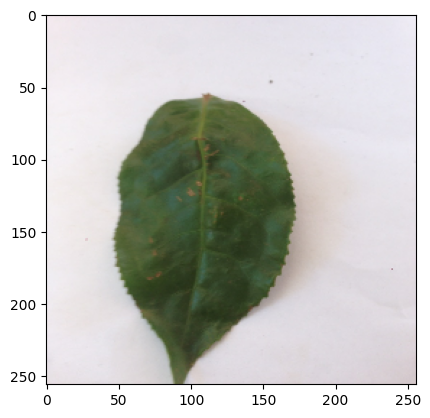

In [19]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [20]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 61ms/step


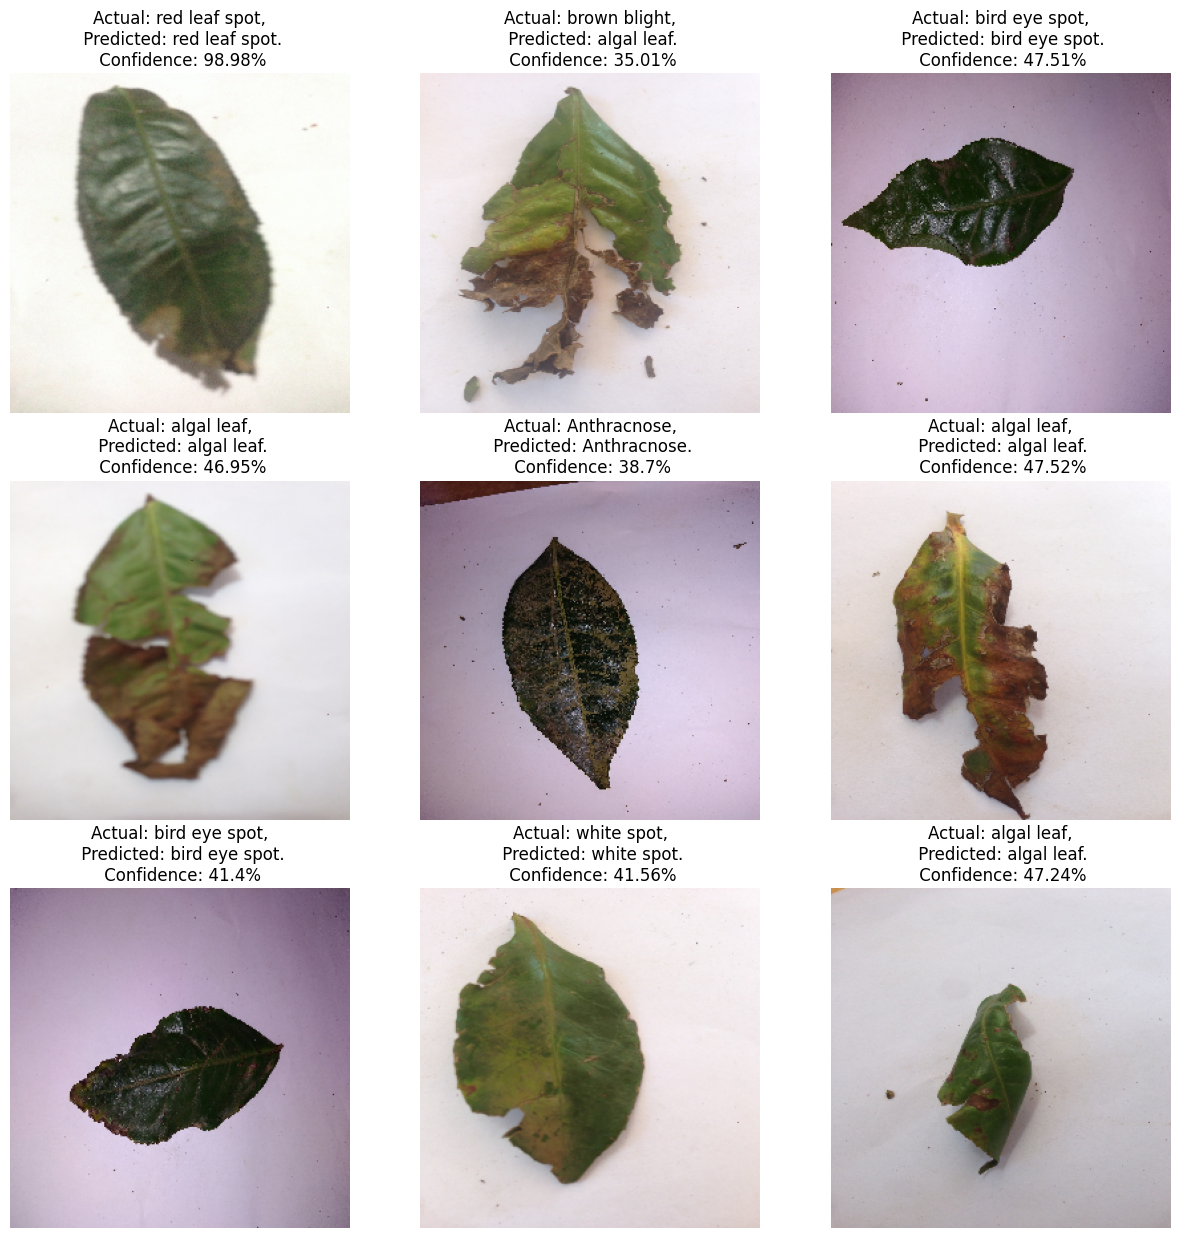

In [21]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
import os
from keras.models import load_model

# Replace 'model' with the name of your model
model_name = 'withauglittle_only basic aug good 3rd model from scratch_decayrate_learning_rate_adamax'

# Path to your Google Drive
drive_path = "/content/drive/MyDrive/colab_NoteBooks"

# Full path for saving the model
save_path = os.path.join(drive_path, model_name)

# Save the model
model.save(save_path)

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
def random_hue(image, max_delta=0.2):
    return tf.image.adjust_hue(image, tf.random.uniform([], -max_delta, max_delta))

def random_brightness(image, max_delta=0.2):
    return tf.image.adjust_brightness(image, tf.random.uniform([], 1-max_delta, 1+max_delta))

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.Lambda(lambda x: random_hue(x)),
    layers.Lambda(lambda x: random_brightness(x)),
    layers.experimental.preprocessing.RandomContrast(0.2),
    layers.experimental.preprocessing.RandomTranslation(0.2, 0.2)
])


In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 8

model = models.Sequential([
    resize_and_rescale,

    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (16, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (16, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (16, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (16, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (16, 60, 60, 64)         

In [ ]:
model.compile(
    optimizer='adamax', #optimizer adamax
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), #loss function
    metrics=['accuracy']  #accuracy
)

In [ ]:
history = model.fit( #traning the model
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1, #have to check
    epochs=50,
)

Epoch 1/50
44/44 [==============================] - 293s 4s/step - loss: 2.0604 - accuracy: 0.1534 - val_loss: 2.0242 - val_accuracy: 0.1625
Epoch 2/50
44/44 [==============================] - 115s 3s/step - loss: 1.9861 - accuracy: 0.1761 - val_loss: 1.9435 - val_accuracy: 0.1875
Epoch 3/50
44/44 [==============================] - 111s 3s/step - loss: 1.7456 - accuracy: 0.2685 - val_loss: 1.4107 - val_accuracy: 0.3500
Epoch 4/50
44/44 [==============================] - 111s 3s/step - loss: 1.4673 - accuracy: 0.3338 - val_loss: 1.2142 - val_accuracy: 0.4250
Epoch 5/50
44/44 [==============================] - 117s 3s/step - loss: 1.4130 - accuracy: 0.3040 - val_loss: 1.1952 - val_accuracy: 0.3250
Epoch 6/50
44/44 [==============================] - 110s 3s/step - loss: 1.3683 - accuracy: 0.3352 - val_loss: 1.2460 - val_accuracy: 0.3125
Epoch 7/50
44/44 [==============================] - 108s 2s/step - loss: 1.2974 - accuracy: 0.3736 - val_loss: 1.1816 - val_accuracy: 0.3875
Epoch 8/50
44

In [ ]:
scores = model.evaluate(test_ds)

In [ ]:
scores

In [ ]:
history

In [ ]:
history.params

In [ ]:
history.history.keys()

In [ ]:
type(history.history['loss'])

In [ ]:

len(history.history['loss'])

In [ ]:
history.history['loss'][:5] # show loss for first 5 epochs

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
import os
from keras.models import load_model

# Replace 'model' with the name of your model
model_name = 'model_old_unchanged_dataset__adamax'

# Path to your Google Drive
drive_path = "/content/drive/MyDrive/colab_NoteBooks"

# Full path for saving the model
save_path = os.path.join(drive_path, model_name)

# Save the model
model.save(save_path)